In [1]:
import sys
import os
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pandas as pd
from util import *
from archs import *
from load_data import *
import train as tr
from network import MNKNet

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')
%matplotlib inline

In [9]:


def test_net(input_var=None):
    
    class FixLayer(lasagne.layers.Layer):
        def get_output_for(self, input, **kwargs):
            return input * (1 - input_var.sum(axis=2))
        
    input_shape=(None, 2, 4, 9)
    input_layer = lasagne.layers.InputLayer(shape=input_shape, input_var=input_var)
    network = lasagne.layers.Conv2DLayer(input_layer, num_filters=64, filter_size=(4,4), pad='full',
                                        nonlinearity=lasagne.nonlinearities.rectify,
                                        W=lasagne.init.GlorotUniform())
    network = lasagne.layers.DropoutLayer(network, p=.75)

    network = lasagne.layers.DenseLayer(network, num_units=36, 
                                        nonlinearity=lasagne.nonlinearities.identity)
    network = FixLayer(network)
    network = lasagne.layers.NonlinearityLayer(network, 
                                               nonlinearity=lasagne.nonlinearities.softmax)
    
    return network

In [10]:
np.random.seed(985227)
CV_nlls, traces, nets = tr.CV_train(test_net, epochs=5000)

Compiling Theano expressions...
Loading data...
Ntrials = 12996


ValueError: Input dimension mis-match. (input[1].shape[1] = 64, input[5].shape[1] = 500)
Apply node that caused the error: Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3) * i4 * i5)}}[(0, 2)](TensorConstant{(1, 1, 1, 1) of 2.0}, Elemwise{add,no_inplace}.0, CorrMM{full, (1, 1)}.0, InplaceDimShuffle{x,0,x,x}.0, Elemwise{Composite{Cast{float64}(LT(i0, i1))}}[(0, 0)].0, Elemwise{Sub}[(0, 1)].0)
Toposort index: 15
Inputs types: [TensorType(float64, (True, True, True, True)), TensorType(float64, 4D), TensorType(float64, 4D), TensorType(float64, (True, False, True, True)), TensorType(float64, 4D), TensorType(float64, (True, False, False, False))]
Inputs shapes: [(1, 1, 1, 1), (500, 64, 7, 12), (500, 64, 7, 12), (1, 64, 1, 1), (500, 64, 7, 12), (1, 500, 2, 9)]
Inputs strides: [(8, 8, 8, 8), (43008, 672, 96, 8), (43008, 672, 96, 8), (512, 8, 8, 8), (43008, 672, 96, 8), (72000, 144, 72, 8)]
Inputs values: [array([[[[ 2.]]]]), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[Reshape{2}(Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3) * i4 * i5)}}[(0, 2)].0, MakeVector{dtype='int64'}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [43]:
(np.array(CV_nlls)).mean()

2.2377492593038744

In [44]:
n = nets[0]

In [8]:
params = lasagne.layers.get_all_param_values(n.network)

for i, p in enumerate(params):
    ps = p.shape
    pp = p.reshape([ps[0], np.product(ps[1:])])
    np.savetxt(str(i//2) + str(i%2), pp, fmt='%.10f')

# Figures

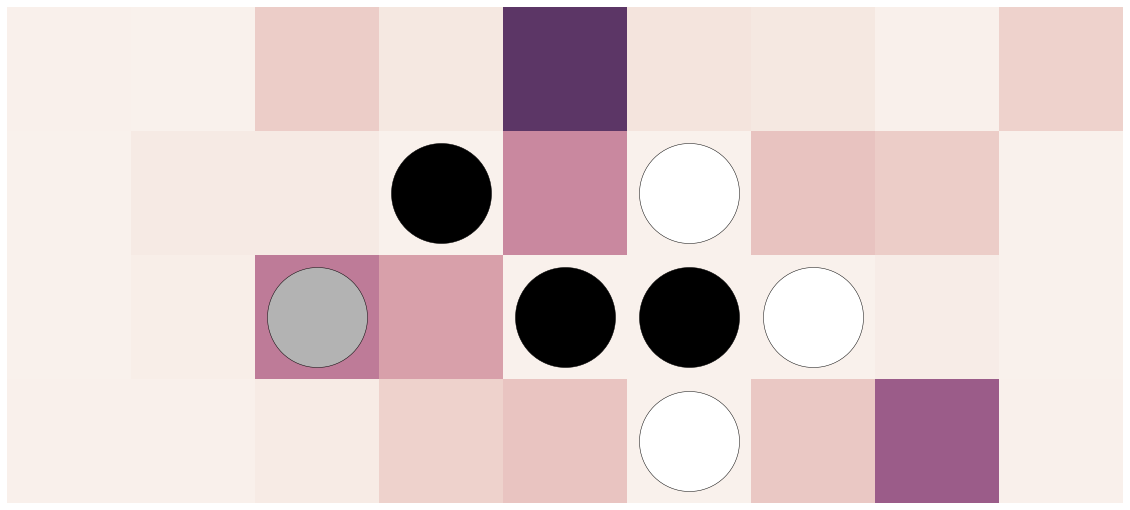

In [36]:
pos = 500 #460
fig, axes = plt.subplots(1, 1, figsize=(20, 10), squeeze=False)
sns.heatmap(probe[pos].reshape([4,9]), square=True, vmin=0, vmax=.25, cbar=False,
            xticklabels=False, yticklabels=False, ax=axes[0,0], annot=False)
p = np.where(n.Xsplit[0][pos, 0]==1)
plt.scatter( .5 + p[1], 3.5 - p[0], c='black', s=10000)
p = np.where(n.Xsplit[0][pos, 1]==1)
plt.scatter( .5 + p[1], 3.5 - p[0], c='white', s=10000)
p = (n.ysplit[0][pos] % 9, n.ysplit[0][pos] // 9)
plt.scatter(p[0] + .5, 3.5 - p[1], c=(.7, .7, .7), s=10000);
# fig.savefig('nice example.png', bbox_inches='tight')

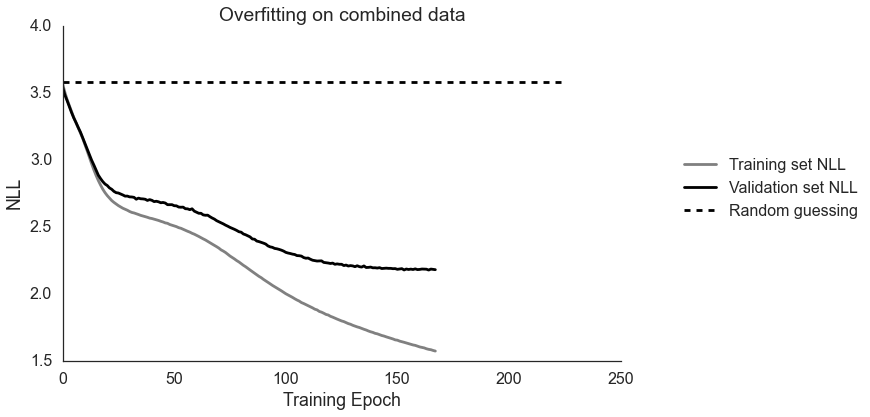

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10,6), squeeze=False)
ep = net.last_epoch
ax = axes[0,0]
ax.plot(np.arange(net.tr_nll.size)[:ep], net.tr_nll[:ep]/33, 
         label='Training set NLL', color='grey')
ax.plot(np.arange(net.val_nll.size)[:ep], net.val_nll[:ep]/5, 
         label='Validation set NLL', color='black')
ax.plot([0, 200], [3.58, 3.58], 'k--', label='Random guessing')
lgd = ax.legend(bbox_to_anchor=(1.45, .65))
ax.set_xlabel('Training Epoch')
ax.set_ylabel('NLL')
ax.set_title('Overfitting on combined data')
sns.despine()
fig.savefig('training_slope.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

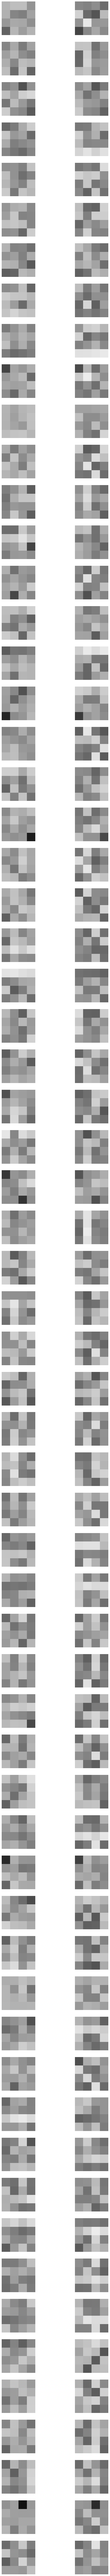

In [46]:
fig, axes = plt.subplots(64, 2, figsize=(10, 192), squeeze=False)

filters = lasagne.layers.get_all_param_values(n.network)[0]

for idx in range(64):
    sns.heatmap(filters[idx,0], square=True, cmap='Greys', fmt= '.2f', 
                vmin=-1.5, vmax=1.5, annot=True,
                ax=axes[idx,0], cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(filters[idx,1], square=True, cmap='Greys', fmt='.2f', 
                vmin=-1.5, vmax=1.5, annot=True,
                ax=axes[idx,1], cbar=False, xticklabels=False, yticklabels=False)

fig.savefig('filters.png', bbox_inches='tight')